# GLM: Linear regression

## Probabilistic reformulation

The linear regression is reformulated to a probabilistic version:

$$
Y = X\beta + \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

The Bayesian linear regression model is given by:

$$
Y \sim \mathcal{N}(X\beta, \sigma^2)
$$

where $\beta \sim \mathcal{N}(0, \sigma^2)$ and $\sigma^2 \sim \text{Inverse-Gamma}(\alpha, \beta)$.    

## Bayesian GLMs in PyMC

### Setup

In [2]:
# Let's import the required modules

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample

print("PyMC version:", pm.__version__)

PyMC version: 5.22.0


In [3]:
# Reproducible examples:

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Nice plots:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating data

In [5]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# Noise 
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

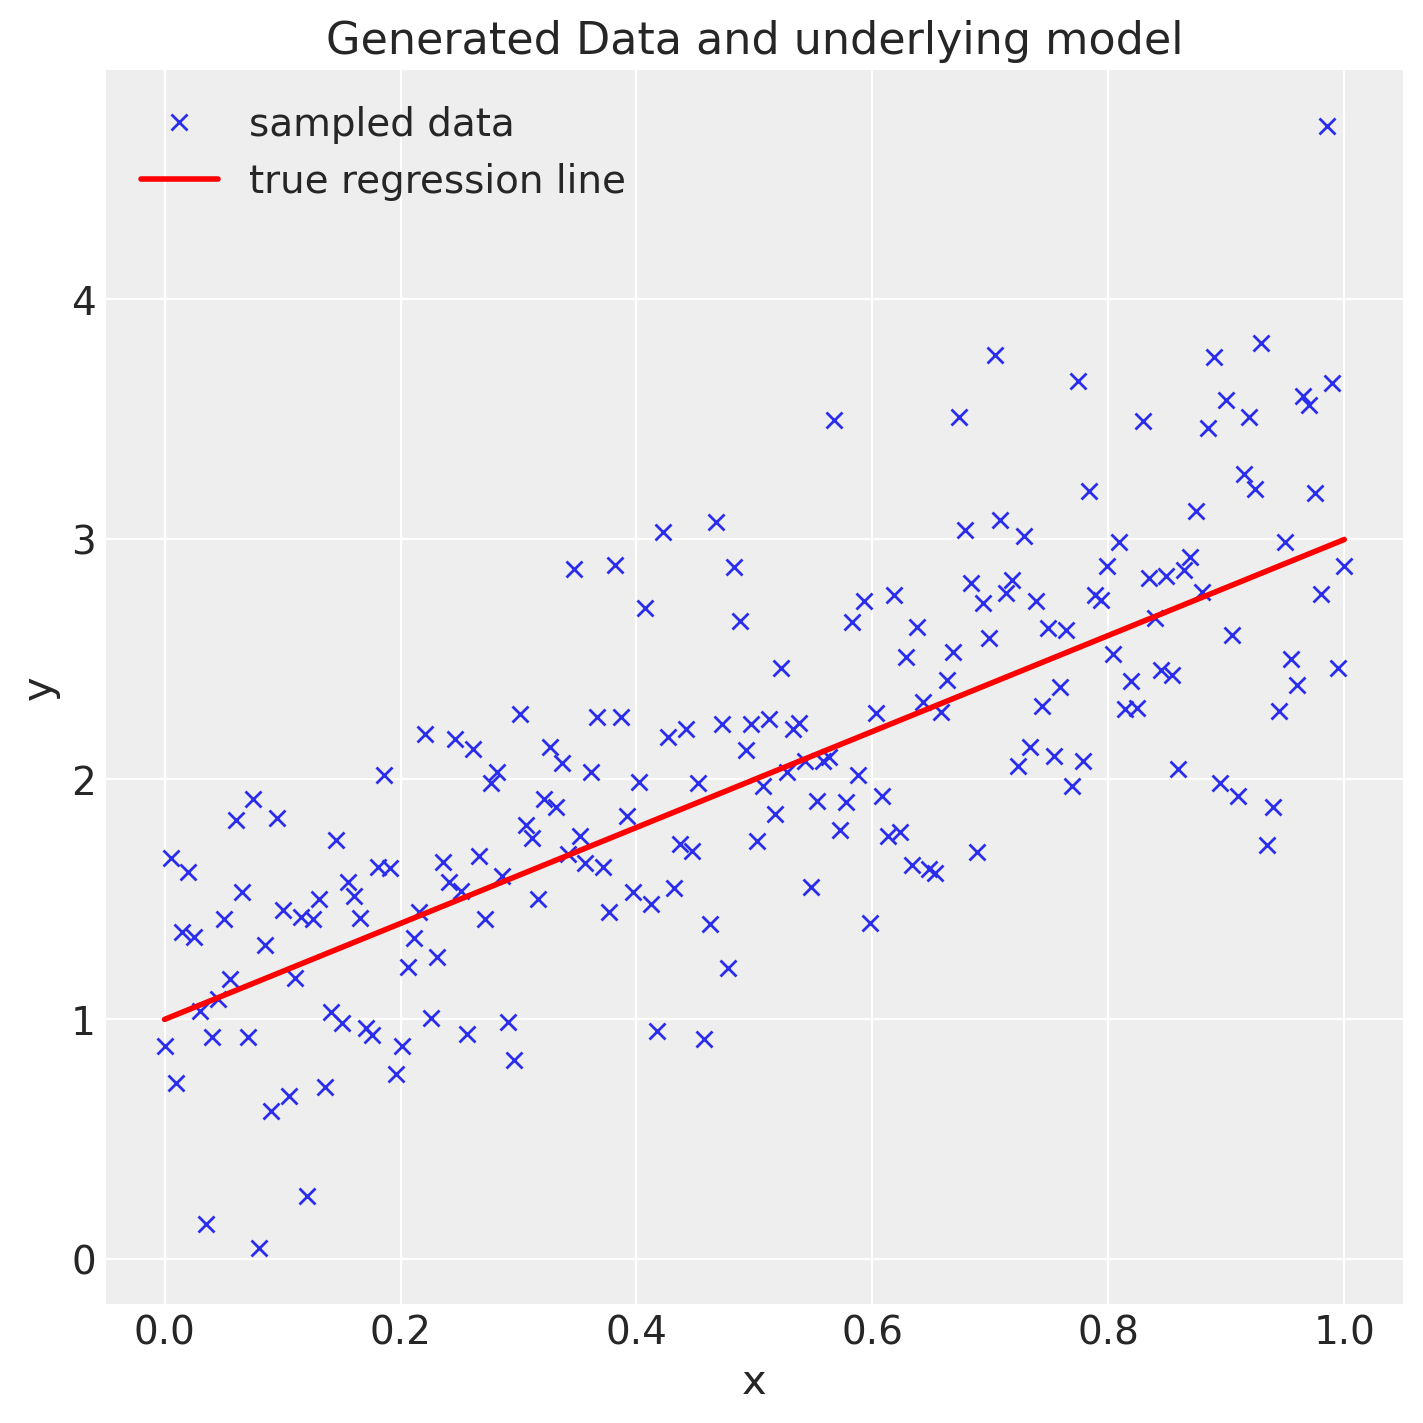

In [8]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, xlabel = "x", ylabel = "y", title="Generated Data and underlying model")
ax.plot(x,y, 'x', label='sampled data')
ax.plot(x, true_regression_line, 'r', label='true regression line', lw=2)
plt.legend(loc=0);

### Estimating the model

In [9]:
with Model() as model:
    # Define priors
    sigma = HalfCauchy('sigma', beta=10)
    intercept = Normal("Intercept", mu=0, sigma=20)
    slope = Normal("slope", mu=0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=data.y)   

    # Inference button below
    # draw 3000 times from posterior samples with defult NUTS
    idata = sample(3000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, slope]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


> Above model is a one-liner in R

### Introducing bambi

In [11]:
import bambi as bmb

In [12]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, x]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


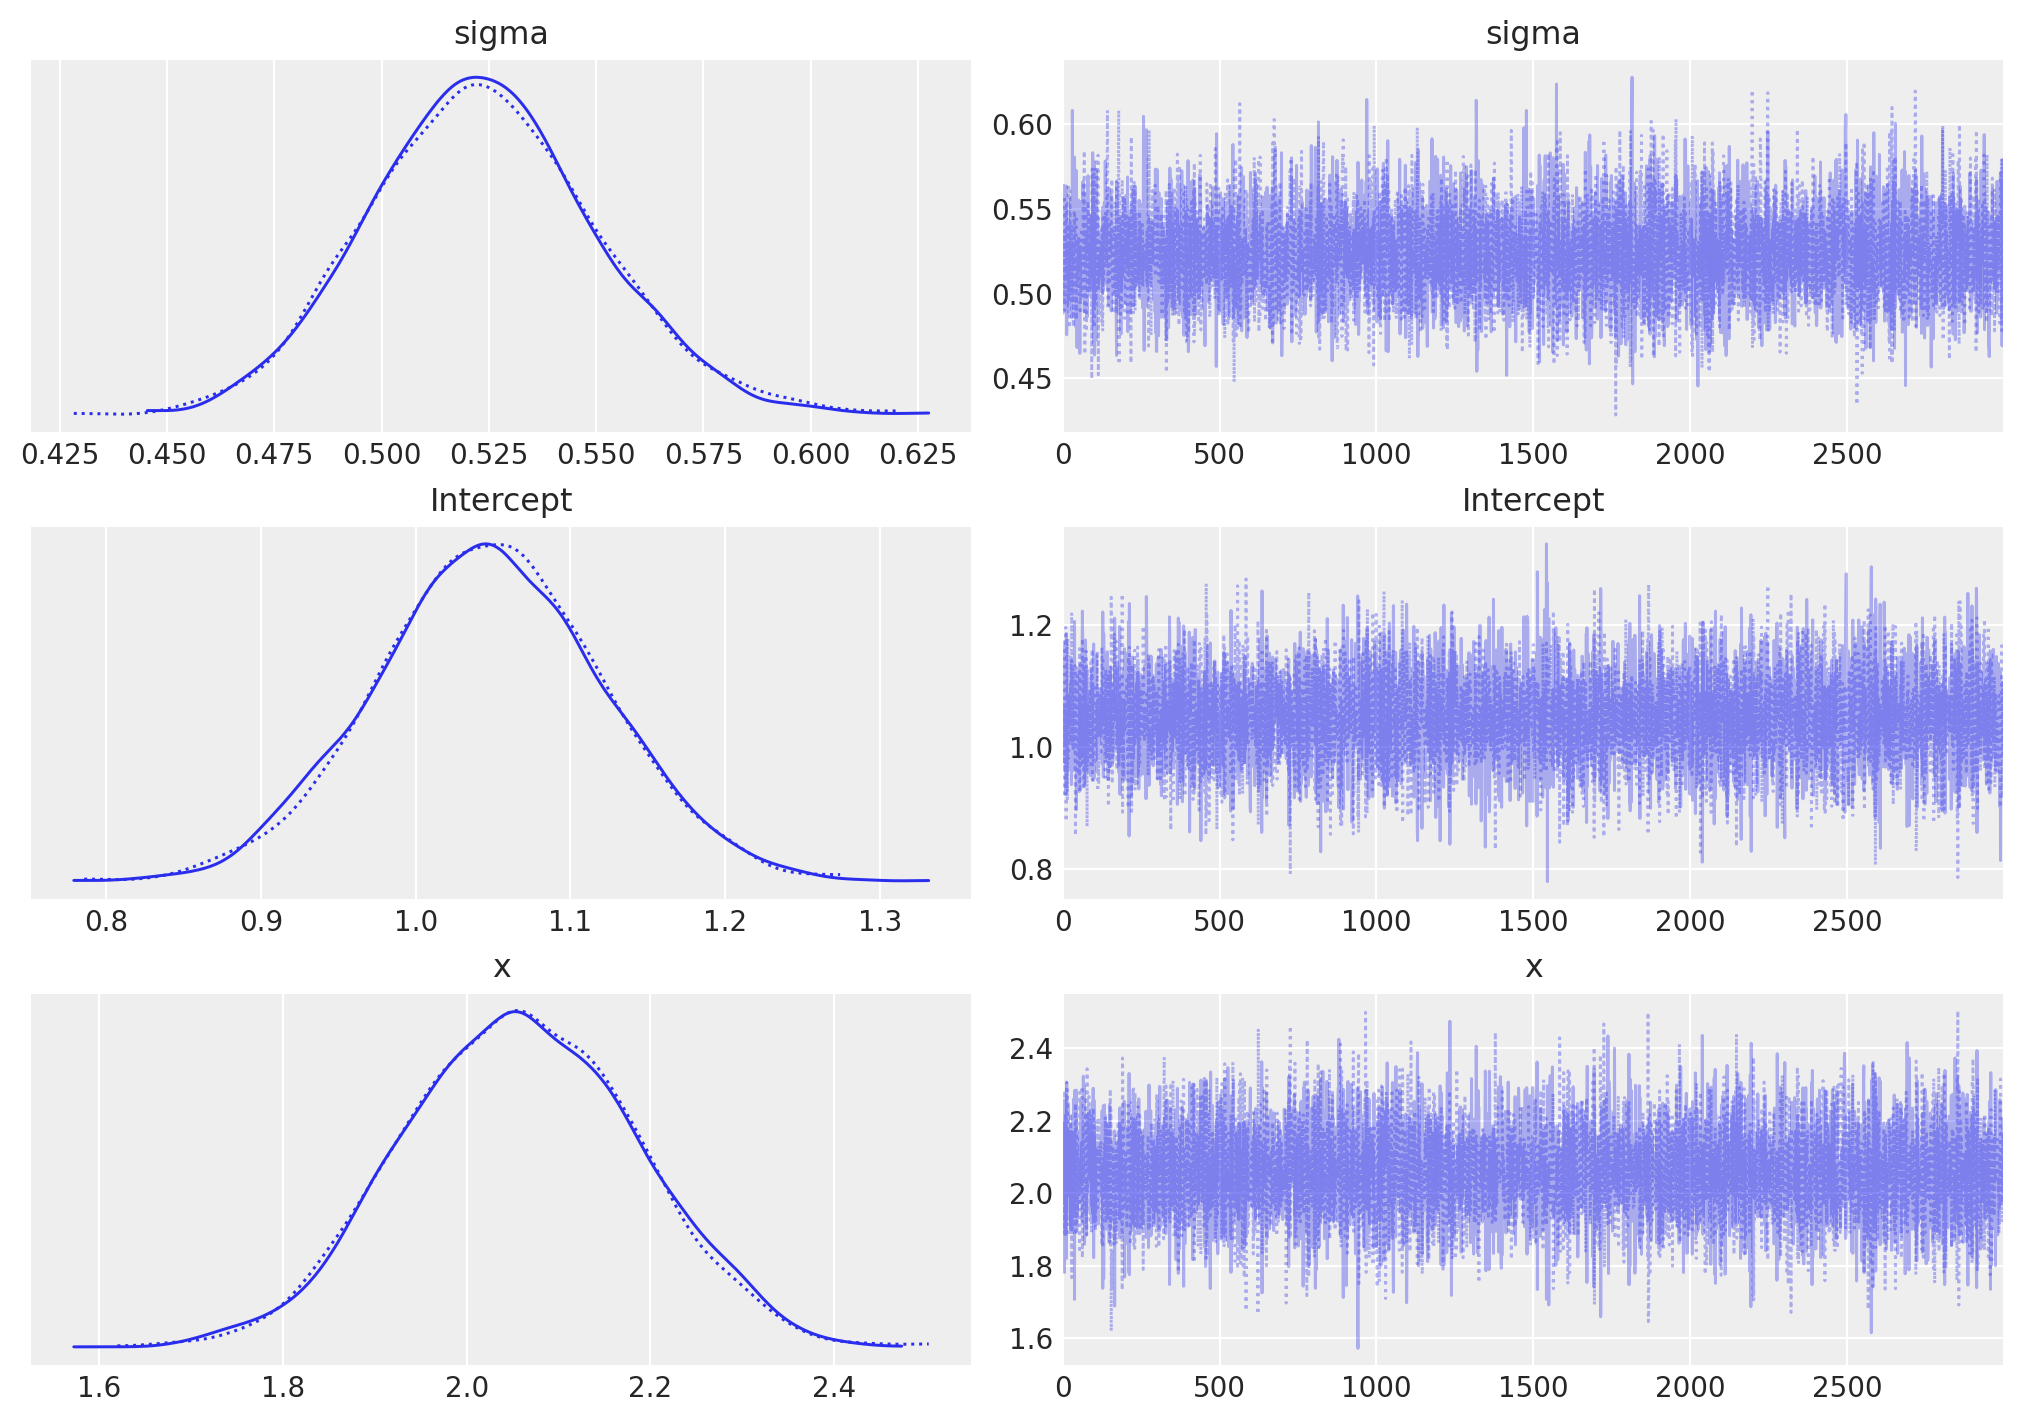

In [13]:
az.plot_trace(idata, figsize=(10, 7));

In [14]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


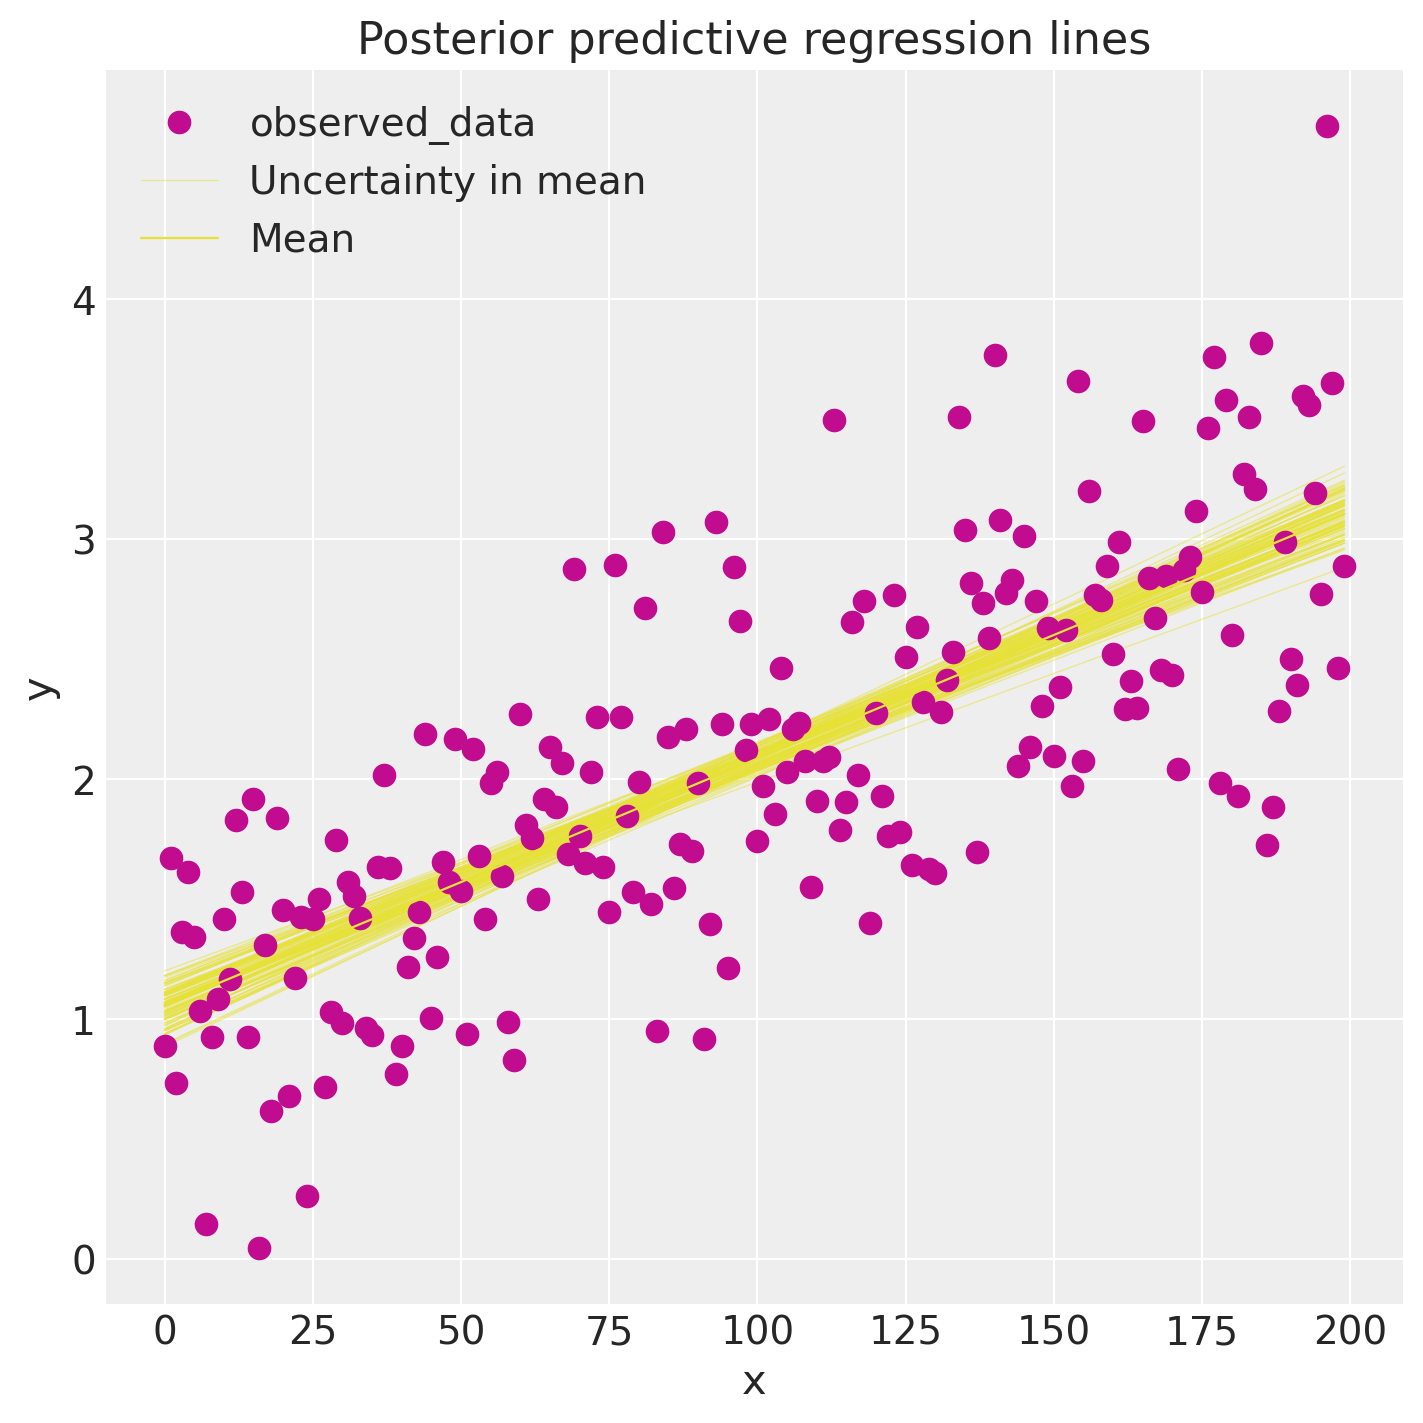

In [15]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

> The regression lines are similar to the true regression line, but the uncertainty (variability in the lines) comes from the limited data.